In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# NeurIPS 2025 Open Polymer Prediction: Baseline Pipeline

This notebook runs the full baseline pipeline for the competition, including:
- Data preparation (LMDB creation)
- Model training and validation
- Test prediction and submission generation


In [2]:
# !pip install torch_geometric
# !pip install rdkit 
# !pip install ogb
# !pip install lmdb
# !pip install lz4

In [3]:
import os
import sys
import sys
sys.path.append('/kaggle/input/polymer')
import random
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from dataset_polymer_fixed import LMDBDataset
from polymer_model import PolymerPredictor
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
# Paths - Fixed for Kaggle environment
if os.path.exists('/kaggle'):
    DATA_ROOT = '/kaggle/input/neurips-open-polymer-prediction-2025'
    CHUNK_DIR = '/kaggle/working/processed_chunks'  # Writable directory
    BACKBONE_PATH = '/kaggle/input/polymer/best_gnn_transformer_hybrid.pt'
else:
    DATA_ROOT = 'data'
    CHUNK_DIR = os.path.join(DATA_ROOT, 'processed_chunks')
    BACKBONE_PATH = 'best_gnn_transformer_hybrid.pt'

TRAIN_LMDB = os.path.join(CHUNK_DIR, 'polymer_train3d_dist.lmdb')
TEST_LMDB = os.path.join(CHUNK_DIR, 'polymer_test3d_dist.lmdb')

print(f"Data root: {DATA_ROOT}")
print(f"LMDB directory: {CHUNK_DIR}")
print(f"Train LMDB: {TRAIN_LMDB}")
print(f"Test LMDB: {TEST_LMDB}")

# Create LMDBs if they don't exist
if not os.path.exists(TRAIN_LMDB) or not os.path.exists(TEST_LMDB):
    print('Building LMDBs...')
    os.makedirs(CHUNK_DIR, exist_ok=True)
    # Run the LMDB builders
    !python build_polymer_lmdb_fixed.py train
    !python build_polymer_lmdb_fixed.py test
    print('LMDB creation complete.')
else:
    print('LMDBs already exist.')


Data root: data
LMDB directory: data\processed_chunks
Train LMDB: data\processed_chunks\polymer_train3d_dist.lmdb
Test LMDB: data\processed_chunks\polymer_test3d_dist.lmdb
LMDBs already exist.


## 2. Check/Create LMDBs (train & test)
If LMDBs are missing, run the builder scripts. Comment out after first run.


In [5]:
# Paths
DATA_ROOT = 'data'
CHUNK_DIR = os.path.join(DATA_ROOT, 'processed_chunks')
TRAIN_LMDB = os.path.join(CHUNK_DIR, 'polymer_train3d_dist.lmdb')
TEST_LMDB = os.path.join(CHUNK_DIR, 'polymer_test3d_dist.lmdb')

# Create LMDBs if they don't exist
if not os.path.exists(TRAIN_LMDB) or not os.path.exists(TEST_LMDB):
    print('Building LMDBs...')
    os.makedirs(CHUNK_DIR, exist_ok=True)
    # Run the LMDB builders
    !python build_polymer_lmdb.py train
    !python build_polymer_lmdb.py test
    print('LMDB creation complete.')
else:
    print('LMDBs already exist.')


LMDBs already exist.


In [ ]:
# Initialize model with correct backbone path
model = PolymerPredictor(
    backbone_ckpt=BACKBONE_PATH,
    n_out=5,
    freeze=True,  # Keep backbone frozen initially
    use_gap=True  # Don't use HOMO-LUMO gap head
).to(device)


print('Model initialized with frozen backbone')
print(f'Total parameters: {sum(p.numel() for p in model.parameters()):,}')
print(f'Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')


Model initialized with frozen backbone
Total parameters: 11,054,086
Trainable parameters: 265,221


c:\Users\mattg\Downloads\kaggle_polymers_competition\polymer_model.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(backbone_ckpt, map_location='cpu'))


In [7]:
# Training helper functions
def weighted_mae_loss(pred, target, mask):
    """Compute weighted MAE loss for polymer properties"""
    valid_pred = pred[mask]
    valid_target = target[mask]
    
    if len(valid_pred) == 0:
        return torch.tensor(0.0, device=pred.device, requires_grad=True)
    
    return F.l1_loss(valid_pred, valid_target)

def compute_metrics(pred, target, mask):
    """Compute validation metrics"""
    label_cols = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']
    results = {}
    
    for i, col in enumerate(label_cols):
        col_mask = mask[:, i]
        if col_mask.sum() > 0:
            col_mae = F.l1_loss(pred[col_mask, i], target[col_mask, i]).item()
            results[f'{col}_MAE'] = col_mae
        else:
            results[f'{col}_MAE'] = float('nan')
    
    # Overall MAE
    if mask.sum() > 0:
        overall_mae = F.l1_loss(pred[mask], target[mask]).item()
        results['Overall_MAE'] = overall_mae
    else:
        results['Overall_MAE'] = float('nan')
    
    return results

print("Training functions defined successfully!")


Training functions defined successfully!


## 3. Train/Validation Split
Create a stratified split based on label availability (how many non-NaN values each row has).


In [8]:
# Load train CSV and create split
train_csv = pd.read_csv(os.path.join(DATA_ROOT, 'train.csv'))
label_cols = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']
ids = train_csv['id'].values

# Stratify by number of non-NaN labels per row
stratify_col = train_csv[label_cols].notna().sum(axis=1)
train_ids, val_ids = train_test_split(
    ids, 
    test_size=0.1,  # 10% validation
    random_state=42,
    stratify=stratify_col
)

print(f'Train/val split: {len(train_ids)} / {len(val_ids)} samples')

# Show label availability stats for both splits
def print_split_stats(split_ids, name):
    split_df = train_csv[train_csv['id'].isin(split_ids)]
    avail = split_df[label_cols].notna().sum()
    print(f'\n{name} set label counts:')
    for col, count in avail.items():
        print(f'{col:>8}: {count:>4} ({count/len(split_ids):>6.1%})')

print_split_stats(train_ids, 'Train')
print_split_stats(val_ids, 'Val')


Train/val split: 7175 / 798 samples

Train set label counts:
      Tg:  456 (  6.4%)
     FFV: 6336 ( 88.3%)
      Tc:  660 (  9.2%)
 Density:  550 (  7.7%)
      Rg:  551 (  7.7%)

Val set label counts:
      Tg:   55 (  6.9%)
     FFV:  694 ( 87.0%)
      Tc:   77 (  9.6%)
 Density:   63 (  7.9%)
      Rg:   63 (  7.9%)


## 4. Data Loading
Create DataLoaders using the fast LMDB datasets for both train and validation sets.


In [9]:
# DataLoader parameters
BATCH_SIZE = 64
NUM_WORKERS = 2  # Adjust based on your CPU

# Create train and validation loaders
train_loader = DataLoader(
    LMDBDataset(train_ids, TRAIN_LMDB),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

val_loader = DataLoader(
    LMDBDataset(val_ids, TRAIN_LMDB),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

print(f'Created DataLoaders with {BATCH_SIZE} batch size')
print(f'Train: {len(train_loader)} batches')
print(f'Val: {len(val_loader)} batches')


[LMDBDataset] Dropped 46 ids not found in LMDB (ids.txt).
[LMDBDataset] Dropped 5 ids not found in LMDB (ids.txt).
Created DataLoaders with 64 batch size
Train: 112 batches
Val: 13 batches


## 5. Weighted MAE (wMAE) Utility
Implement the competition's weighted MAE metric. We approximate test ranges using the train set since true test ranges are hidden.


In [10]:
def compute_wmae(pred, true, mask=None, n_t=None, delta_t=None, eps=1e-6):
    """
    Robust weighted MAE with protections against NaN/Inf:
      - Drops tasks with n_t==0
      - Replaces non-finite or non-positive delta_t with eps/fallback
      - Drops tasks with no labels present in this eval split
      - Falls back to equal weights over present tasks if normalization degenerates
    Returns: wmae (float), mae_per_task (float[5]), weights (float[5])
    """
    # to numpy
    if isinstance(pred, torch.Tensor): pred = pred.detach().cpu().numpy()
    if isinstance(true, torch.Tensor): true = true.detach().cpu().numpy()
    if mask is None:
        mask = ~np.isnan(true)
    elif isinstance(mask, torch.Tensor):
        mask = mask.detach().cpu().numpy().astype(bool)
    else:
        mask = mask.astype(bool)

    pred = pred.astype(np.float64)
    true = true.astype(np.float64)

    # absolute error, masked
    abs_err = np.abs(pred - true)
    abs_err[~mask] = 0.0

    # counts per task (how many valid labels in this split)
    counts_val = mask.sum(axis=0)
    # MAE per task (safe divide)
    mae_per_task = abs_err.sum(axis=0) / np.maximum(counts_val, 1)

    # n_t (from train) and delta_t (range) — sanitize
    if n_t is None:
        n_t_s = counts_val.astype(np.float64)
    else:
        n_t_s = np.asarray(n_t, dtype=np.float64)

    if delta_t is None:
        # compute from the current 'true' using only observed values
        with np.errstate(invalid='ignore'):
            tmax = np.nanmax(np.where(mask, true, np.nan), axis=0)
            tmin = np.nanmin(np.where(mask, true, np.nan), axis=0)
        delta_t_s = tmax - tmin
    else:
        delta_t_s = np.asarray(delta_t, dtype=np.float64)

    # Replace bad ranges with eps
    bad_range = (~np.isfinite(delta_t_s)) | (delta_t_s <= 0)
    delta_t_s = np.where(bad_range, eps, delta_t_s)

    # Any task with no training labels gets zero weight
    bad_count = (~np.isfinite(n_t_s)) | (n_t_s <= 0)
    n_t_s = np.where(bad_count, 0.0, n_t_s)

    # Raw weights
    weight_raw = np.zeros_like(mae_per_task, dtype=np.float64)
    valid_train = (n_t_s > 0)
    weight_raw[valid_train] = 1.0 / np.sqrt(n_t_s[valid_train] * delta_t_s[valid_train])

    # Drop tasks not present in this val split
    present_val = (counts_val > 0)
    weight_raw[~present_val] = 0.0

    denom = weight_raw.sum()
    if denom <= 0 or not np.isfinite(denom):
        # Fallback: equal weights over tasks present in val
        weights = np.zeros_like(weight_raw)
        m = present_val.sum()
        if m > 0:
            weights[present_val] = 1.0 / m
    else:
        weights = weight_raw / denom

    wmae = float((mae_per_task * weights).sum())
    return wmae, mae_per_task.astype(np.float64), weights.astype(np.float64)


# Precompute n_t and delta_t from train set
label_cols = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']
train_labels = train_csv[label_cols].values.astype(np.float64)

# Counts ignoring NaN
n_t = np.sum(~np.isnan(train_labels), axis=0)

# Robust range: use percentiles to avoid outliers; fallback to max-min; final eps if still bad
p1  = np.nanpercentile(train_labels, 1,  axis=0)
p99 = np.nanpercentile(train_labels, 99, axis=0)
delta_t = p99 - p1

fallback = (np.nanmax(train_labels, axis=0) - np.nanmin(train_labels, axis=0))
delta_t = np.where((~np.isfinite(delta_t)) | (delta_t <= 0), fallback, delta_t)
delta_t = np.where((~np.isfinite(delta_t)) | (delta_t <= 0), 1.0, delta_t)  # final minimum


print('Label statistics from train set:')
print('\nSample counts (n_t):')
for col, count in zip(label_cols, n_t):
    print(f'{col:>8}: {count:>6}')
print('\nValue ranges (delta_t):')
for col, delta in zip(label_cols, delta_t):
    print(f'{col:>8}: {delta:>8.3f}')

# Compute and show weights
dummy = np.zeros((1, len(label_cols)), dtype=np.float64)
_, _, weights = compute_wmae(dummy, dummy, n_t=n_t, delta_t=delta_t)
print('\nResulting weights:')
for col, weight in zip(label_cols, weights):
    print(f'{col:>8}: {weight:>8.3f}')


Label statistics from train set:

Sample counts (n_t):
      Tg:    511
     FFV:   7030
      Tc:    737
 Density:    613
      Rg:    614

Value ranges (delta_t):
      Tg:  513.394
     FFV:    0.145
      Tc:    0.366
 Density:    0.743
      Rg:   18.170

Resulting weights:
      Tg:    0.013
     FFV:    0.208
      Tc:    0.405
 Density:    0.311
      Rg:    0.063


## 6. Model Setup
Initialize the PolymerPredictor with frozen backbone weights and configure training.


In [11]:
# Model initialization
model = PolymerPredictor(
    backbone_ckpt='best_gnn_transformer_hybrid.pt',
    freeze=True,  # Freeze backbone weights
    use_gap=True  # Don't use gap feature initially
).to(device)

# Optimizer (only train the head)
optimizer = torch.optim.AdamW(
    model.head.parameters(),
    lr=1e-4,
    weight_decay=1e-5
)

# Training config
EPOCHS = 100
EARLY_STOP_PATIENCE = 8  # Stop if no improvement for this many epochs

print(f'Model initialized on {device}')
print('Trainable parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))


Model initialized on cuda
Trainable parameters: 265221


c:\Users\mattg\Downloads\kaggle_polymers_competition\polymer_model.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(backbone_ckpt, map_location='cpu'))


## 7. Training Loop
Train for ~30 epochs with early stopping based on validation wMAE.


In [12]:
# Training loop with early stopping
best_val_wmae = float('inf')
patience_counter = 0
train_losses = []
val_wmaes = []

for epoch in range(EPOCHS):
    # Training
    model.train()
    train_loss = 0
    
    for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS} - Training'):
        batch = batch.to(device)
        pred = model(batch)
        
        # Compute loss only on non-NaN labels
        mask = ~torch.isnan(batch.y)
        loss = torch.abs(pred - batch.y)[mask].mean()  # MAE loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * batch.num_graphs
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_preds, val_trues, val_masks = [], [], []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validation'):
            batch = batch.to(device)
            pred = model(batch)
            val_preds.append(pred.cpu())
            val_trues.append(batch.y.cpu())
            val_masks.append(~torch.isnan(batch.y.cpu()))
    
    val_preds = torch.cat(val_preds, dim=0)
    val_trues = torch.cat(val_trues, dim=0)
    val_masks = torch.cat(val_masks, dim=0)
    
    # Compute validation wMAE
    val_wmae, val_maes, w = compute_wmae(
    val_preds, 
    val_trues, 
    val_masks,
    n_t=n_t, 
    delta_t=delta_t
    )

    # Safety: never let NaN/Inf crash early-stopping
    if not np.isfinite(val_wmae):
        print("Warning: non-finite val_wmae; setting to +inf for early stopping.")
        val_wmae = float('inf')

      
    val_wmaes.append(val_wmae)
    
    # Print epoch stats
    print(f'\nEpoch {epoch+1}/{EPOCHS}:')
    print(f'Train loss: {train_loss:.4f}')
    print(f'Val wMAE: {val_wmae:.4f}')
    print('Val MAEs:', ' '.join(f'{mae:.4f}' for mae in val_maes))
    
    # Early stopping
    if val_wmae < best_val_wmae:
        best_val_wmae = val_wmae
        patience_counter = 0
        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_wmae': val_wmae,
        }, 'best_polymer_model.pt')
        print('Saved new best model!')
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOP_PATIENCE:
            print(f'\nEarly stopping after {epoch+1} epochs!')
            break

print(f'\nTraining complete! Best validation wMAE: {best_val_wmae:.4f}')

Epoch 1/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 1/100:
Train loss: 6.5617
Val wMAE: 1.7467
Val MAEs: 91.3499 0.0274 0.1031 0.2269 7.0556
Saved new best model!


Epoch 2/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 2/100:
Train loss: 5.6043
Val wMAE: 1.5033
Val MAEs: 84.9728 0.0335 0.0795 0.1367 5.0793
Saved new best model!


Epoch 3/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 3/100:
Train loss: 5.3227
Val wMAE: 1.4058
Val MAEs: 81.1845 0.0265 0.0521 0.1055 4.6641
Saved new best model!


Epoch 4/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 4/100:
Train loss: 5.1331
Val wMAE: 1.3950
Val MAEs: 78.7591 0.1102 0.0910 0.1386 4.3021
Saved new best model!


Epoch 5/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 5/100:
Train loss: 4.9622
Val wMAE: 1.3307
Val MAEs: 76.9008 0.0203 0.0677 0.1498 4.0539
Saved new best model!


Epoch 6/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 6/100:
Train loss: 4.8359
Val wMAE: 1.2926
Val MAEs: 75.4513 0.0431 0.0451 0.1364 3.8841
Saved new best model!


Epoch 7/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 7/100:
Train loss: 4.7630
Val wMAE: 1.2660
Val MAEs: 74.6713 0.0303 0.0459 0.1181 3.7493
Saved new best model!


Epoch 8/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 8/100:
Train loss: 4.7122
Val wMAE: 1.2523
Val MAEs: 74.2336 0.0663 0.0501 0.0801 3.6633
Saved new best model!


Epoch 9/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 9/100:
Train loss: 4.6792
Val wMAE: 1.2483
Val MAEs: 74.2477 0.0350 0.0597 0.0886 3.5976
Saved new best model!


Epoch 10/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 10/100:
Train loss: 4.6634
Val wMAE: 1.2557
Val MAEs: 74.2157 0.0892 0.0610 0.0840 3.5562


Epoch 11/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 11/100:
Train loss: 4.6484
Val wMAE: 1.2618
Val MAEs: 74.0725 0.1150 0.0450 0.1221 3.5118


Epoch 12/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 12/100:
Train loss: 4.6373
Val wMAE: 1.2397
Val MAEs: 73.7862 0.0601 0.0551 0.0918 3.4863
Saved new best model!


Epoch 13/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 13/100:
Train loss: 4.6116
Val wMAE: 1.2264
Val MAEs: 73.5948 0.0257 0.0490 0.0892 3.4803
Saved new best model!


Epoch 14/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 14/100:
Train loss: 4.5965
Val wMAE: 1.2447
Val MAEs: 73.4176 0.0253 0.0478 0.1612 3.4600


Epoch 15/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 15/100:
Train loss: 4.6079
Val wMAE: 1.2208
Val MAEs: 73.1990 0.0175 0.0462 0.0983 3.4737
Saved new best model!


Epoch 16/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 16/100:
Train loss: 4.5684
Val wMAE: 1.2675
Val MAEs: 73.0075 0.0455 0.1167 0.1534 3.4350


Epoch 17/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 17/100:
Train loss: 4.5639
Val wMAE: 1.2093
Val MAEs: 72.7759 0.0292 0.0457 0.0826 3.4201
Saved new best model!


Epoch 18/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 18/100:
Train loss: 4.5308
Val wMAE: 1.2090
Val MAEs: 72.5310 0.0257 0.0455 0.0843 3.4702
Saved new best model!


Epoch 19/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 19/100:
Train loss: 4.5804
Val wMAE: 1.2093
Val MAEs: 72.3252 0.0674 0.0471 0.0764 3.4074


Epoch 20/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 20/100:
Train loss: 4.5382
Val wMAE: 1.2075
Val MAEs: 72.0757 0.0220 0.0542 0.0929 3.4537
Saved new best model!


Epoch 21/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 21/100:
Train loss: 4.5424
Val wMAE: 1.1911
Val MAEs: 71.8817 0.0259 0.0397 0.0750 3.4014
Saved new best model!


Epoch 22/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 22/100:
Train loss: 4.5074
Val wMAE: 1.1975
Val MAEs: 71.6492 0.0177 0.0652 0.0777 3.4022


Epoch 23/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 23/100:
Train loss: 4.4751
Val wMAE: 1.2042
Val MAEs: 71.3733 0.0936 0.0444 0.0911 3.3814


Epoch 24/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 24/100:
Train loss: 4.4794
Val wMAE: 1.1810
Val MAEs: 71.1571 0.0297 0.0448 0.0689 3.3754
Saved new best model!


Epoch 25/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 25/100:
Train loss: 4.4722
Val wMAE: 1.1858
Val MAEs: 70.8471 0.0292 0.0605 0.0781 3.3716


Epoch 26/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 26/100:
Train loss: 4.3984
Val wMAE: 1.1882
Val MAEs: 70.5802 0.0213 0.0600 0.1049 3.3606


Epoch 27/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 27/100:
Train loss: 4.4201
Val wMAE: 1.1814
Val MAEs: 70.3118 0.0243 0.0450 0.1139 3.3507


Epoch 28/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 28/100:
Train loss: 4.3616
Val wMAE: 1.1763
Val MAEs: 70.0054 0.0167 0.0437 0.1195 3.3386
Saved new best model!


Epoch 29/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 29/100:
Train loss: 4.3946
Val wMAE: 1.1843
Val MAEs: 69.6648 0.0491 0.0499 0.1305 3.3342


Epoch 30/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 30/100:
Train loss: 4.3510
Val wMAE: 1.1626
Val MAEs: 69.3527 0.0217 0.0492 0.0950 3.3236
Saved new best model!


Epoch 31/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 31/100:
Train loss: 4.3399
Val wMAE: 1.1555
Val MAEs: 69.0362 0.0281 0.0441 0.0921 3.3022
Saved new best model!


Epoch 32/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 32/100:
Train loss: 4.3444
Val wMAE: 1.1660
Val MAEs: 68.7656 0.0245 0.0436 0.1355 3.3246


Epoch 33/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 33/100:
Train loss: 4.3096
Val wMAE: 1.1751
Val MAEs: 68.4964 0.1041 0.0549 0.1179 3.2768


Epoch 34/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 34/100:
Train loss: 4.3207
Val wMAE: 1.1348
Val MAEs: 68.1446 0.0279 0.0425 0.0727 3.2641
Saved new best model!


Epoch 35/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 35/100:
Train loss: 4.3163
Val wMAE: 1.1853
Val MAEs: 67.8154 0.0219 0.1639 0.0997 3.2405


Epoch 36/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 36/100:
Train loss: 4.2821
Val wMAE: 1.1358
Val MAEs: 67.6126 0.0430 0.0453 0.0914 3.2293


Epoch 37/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 37/100:
Train loss: 4.2348
Val wMAE: 1.1321
Val MAEs: 67.1963 0.0362 0.0460 0.0999 3.2321
Saved new best model!


Epoch 38/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 38/100:
Train loss: 4.2162
Val wMAE: 1.1423
Val MAEs: 66.7663 0.0170 0.0949 0.1071 3.1966


Epoch 39/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 39/100:
Train loss: 4.2465
Val wMAE: 1.1490
Val MAEs: 66.5727 0.1143 0.0691 0.1071 3.1859


Epoch 40/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 40/100:
Train loss: 4.2164
Val wMAE: 1.1190
Val MAEs: 66.2033 0.0184 0.0662 0.0953 3.1813
Saved new best model!


Epoch 41/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 41/100:
Train loss: 4.1861
Val wMAE: 1.1126
Val MAEs: 65.8869 0.0855 0.0441 0.0758 3.1613
Saved new best model!


Epoch 42/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 42/100:
Train loss: 4.1962
Val wMAE: 1.1111
Val MAEs: 65.5361 0.0523 0.0533 0.0994 3.1436
Saved new best model!


Epoch 43/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 43/100:
Train loss: 4.2104
Val wMAE: 1.0952
Val MAEs: 65.1989 0.0267 0.0495 0.0847 3.1420
Saved new best model!


Epoch 44/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 44/100:
Train loss: 4.1304
Val wMAE: 1.1319
Val MAEs: 64.9564 0.0421 0.1003 0.1430 3.1080


Epoch 45/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 45/100:
Train loss: 4.1681
Val wMAE: 1.0864
Val MAEs: 64.6497 0.0175 0.0473 0.0842 3.1622
Saved new best model!


Epoch 46/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 46/100:
Train loss: 4.1087
Val wMAE: 1.0913
Val MAEs: 64.3141 0.0621 0.0399 0.1088 3.0867


Epoch 47/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 47/100:
Train loss: 4.0939
Val wMAE: 1.0876
Val MAEs: 63.9227 0.0459 0.0644 0.0827 3.1340


Epoch 48/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 48/100:
Train loss: 4.0990
Val wMAE: 1.0853
Val MAEs: 63.6956 0.0221 0.0573 0.1118 3.1250
Saved new best model!


Epoch 49/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 49/100:
Train loss: 4.0497
Val wMAE: 1.0650
Val MAEs: 63.3601 0.0175 0.0481 0.0840 3.0839
Saved new best model!


Epoch 50/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 50/100:
Train loss: 4.0561
Val wMAE: 1.0662
Val MAEs: 63.1148 0.0567 0.0445 0.0760 3.0856


Epoch 51/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 51/100:
Train loss: 4.0371
Val wMAE: 1.0722
Val MAEs: 62.6586 0.0791 0.0435 0.0936 3.1200


Epoch 52/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 52/100:
Train loss: 4.0399
Val wMAE: 1.0715
Val MAEs: 62.5641 0.0262 0.0880 0.0820 3.0753


Epoch 53/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 53/100:
Train loss: 4.0113
Val wMAE: 1.0516
Val MAEs: 62.1795 0.0374 0.0457 0.0815 3.0765
Saved new best model!


Epoch 54/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 54/100:
Train loss: 4.0041
Val wMAE: 1.0584
Val MAEs: 61.9962 0.0410 0.0511 0.1181 2.9934


Epoch 55/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 55/100:
Train loss: 3.9719
Val wMAE: 1.0398
Val MAEs: 61.5836 0.0254 0.0460 0.0838 3.0374
Saved new best model!


Epoch 56/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 56/100:
Train loss: 3.9420
Val wMAE: 1.0437
Val MAEs: 61.1577 0.0597 0.0449 0.1030 2.9862


Epoch 57/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 57/100:
Train loss: 3.9779
Val wMAE: 1.0564
Val MAEs: 60.9508 0.0397 0.0724 0.1215 3.0284


Epoch 58/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 58/100:
Train loss: 3.9386
Val wMAE: 1.0372
Val MAEs: 60.6689 0.0542 0.0584 0.0871 2.9937
Saved new best model!


Epoch 59/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 59/100:
Train loss: 3.9240
Val wMAE: 1.0478
Val MAEs: 60.5762 0.0418 0.0447 0.1391 3.0532


Epoch 60/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 60/100:
Train loss: 3.9170
Val wMAE: 1.0305
Val MAEs: 60.2014 0.0602 0.0501 0.0936 2.9846
Saved new best model!


Epoch 61/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 61/100:
Train loss: 3.9157
Val wMAE: 1.0564
Val MAEs: 60.2221 0.0664 0.0660 0.1602 2.9394


Epoch 62/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 62/100:
Train loss: 3.8949
Val wMAE: 1.0341
Val MAEs: 59.9251 0.0312 0.0774 0.0867 3.0531


Epoch 63/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 63/100:
Train loss: 3.8641
Val wMAE: 1.0170
Val MAEs: 59.8374 0.0180 0.0569 0.1005 2.9070
Saved new best model!


Epoch 64/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 64/100:
Train loss: 3.9080
Val wMAE: 1.0252
Val MAEs: 59.7208 0.0179 0.0790 0.1086 2.8790


Epoch 65/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 65/100:
Train loss: 3.8570
Val wMAE: 1.0085
Val MAEs: 59.2848 0.0264 0.0503 0.0792 3.0055
Saved new best model!


Epoch 66/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 66/100:
Train loss: 3.8431
Val wMAE: 1.0143
Val MAEs: 59.1076 0.0859 0.0527 0.0838 2.8989


Epoch 67/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 67/100:
Train loss: 3.8415
Val wMAE: 1.0069
Val MAEs: 59.0061 0.0173 0.0489 0.1062 2.9429
Saved new best model!


Epoch 68/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 68/100:
Train loss: 3.8161
Val wMAE: 1.0110
Val MAEs: 58.8417 0.0306 0.0747 0.0955 2.8851


Epoch 69/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 69/100:
Train loss: 3.8132
Val wMAE: 1.0071
Val MAEs: 58.7962 0.0234 0.0548 0.1254 2.8367


Epoch 70/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 70/100:
Train loss: 3.8180
Val wMAE: 0.9997
Val MAEs: 58.6598 0.0595 0.0537 0.0798 2.8605
Saved new best model!


Epoch 71/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 71/100:
Train loss: 3.7781
Val wMAE: 1.0030
Val MAEs: 58.4358 0.0214 0.0924 0.0779 2.8448


Epoch 72/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 72/100:
Train loss: 3.8132
Val wMAE: 1.0072
Val MAEs: 58.3685 0.0193 0.0982 0.0880 2.8462


Epoch 73/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 73/100:
Train loss: 3.7875
Val wMAE: 0.9982
Val MAEs: 58.3361 0.0379 0.0672 0.0791 2.8919
Saved new best model!


Epoch 74/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 74/100:
Train loss: 3.7745
Val wMAE: 0.9919
Val MAEs: 58.2523 0.0201 0.0625 0.0870 2.8581
Saved new best model!


Epoch 75/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 75/100:
Train loss: 3.7701
Val wMAE: 1.0093
Val MAEs: 58.1387 0.0190 0.0666 0.1358 2.8952


Epoch 76/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 76/100:
Train loss: 3.7488
Val wMAE: 0.9834
Val MAEs: 58.2384 0.0213 0.0492 0.0840 2.8224
Saved new best model!


Epoch 77/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 77/100:
Train loss: 3.7583
Val wMAE: 0.9886
Val MAEs: 58.1837 0.0199 0.0497 0.0920 2.8782


Epoch 78/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 78/100:
Train loss: 3.7741
Val wMAE: 0.9883
Val MAEs: 58.1269 0.0431 0.0521 0.0953 2.7767


Epoch 79/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 79/100:
Train loss: 3.7673
Val wMAE: 0.9984
Val MAEs: 58.0680 0.0770 0.0517 0.1033 2.7997


Epoch 80/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 80/100:
Train loss: 3.7471
Val wMAE: 0.9997
Val MAEs: 58.0944 0.0367 0.0890 0.0868 2.7910


Epoch 81/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 81/100:
Train loss: 3.7184
Val wMAE: 1.0082
Val MAEs: 58.0308 0.0815 0.0524 0.1064 2.9282


Epoch 82/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 82/100:
Train loss: 3.7006
Val wMAE: 0.9854
Val MAEs: 58.0598 0.0408 0.0516 0.0816 2.8230


Epoch 83/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 83/100:
Train loss: 3.7255
Val wMAE: 0.9990
Val MAEs: 58.0563 0.0608 0.0594 0.1101 2.7827


Epoch 84/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 84/100:
Train loss: 3.7232
Val wMAE: 0.9815
Val MAEs: 58.1165 0.0150 0.0485 0.0971 2.7771
Saved new best model!


Epoch 85/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 85/100:
Train loss: 3.7132
Val wMAE: 0.9938
Val MAEs: 58.2002 0.0208 0.0900 0.0799 2.7550


Epoch 86/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 86/100:
Train loss: 3.6993
Val wMAE: 0.9838
Val MAEs: 58.1776 0.0495 0.0499 0.0809 2.7595


Epoch 87/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 87/100:
Train loss: 3.6768
Val wMAE: 1.0171
Val MAEs: 58.2053 0.0257 0.0979 0.1481 2.7196


Epoch 88/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 88/100:
Train loss: 3.7268
Val wMAE: 0.9955
Val MAEs: 58.2833 0.0264 0.0680 0.1076 2.7510


Epoch 89/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 89/100:
Train loss: 3.6711
Val wMAE: 0.9887
Val MAEs: 58.3336 0.0287 0.0457 0.1063 2.7741


Epoch 90/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 90/100:
Train loss: 3.6808
Val wMAE: 0.9951
Val MAEs: 58.2867 0.0240 0.0509 0.1291 2.7551


Epoch 91/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 91/100:
Train loss: 3.6960
Val wMAE: 1.0025
Val MAEs: 58.2858 0.0354 0.0836 0.0923 2.8071


Epoch 92/100 - Training:   0%|          | 0/112 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 92/100:
Train loss: 3.6633
Val wMAE: 1.0119
Val MAEs: 58.3581 0.0343 0.0496 0.1805 2.7277

Early stopping after 92 epochs!

Training complete! Best validation wMAE: 0.9815


# Fine Tuning

In [13]:
# Unfreeze backbone and set up fine-tuning 
# 1) Unfreeze backbone parameters
if hasattr(model, "backbone"):
    for p in model.backbone.parameters():
        p.requires_grad = True
else:
    # Fallbacks in case the attribute is named differently in PolymerPredictor
    for attr in ["encoder", "gnn", "trunk"]:
        if hasattr(model, attr):
            for p in getattr(model, attr).parameters():
                p.requires_grad = True
            break
    else:
        raise AttributeError("Could not find backbone module on model (tried: backbone, encoder, gnn, trunk).")

# 2) (Optional) If PolymerPredictor tracks a freeze flag internally, flip it
if hasattr(model, "frozen"):
    model.frozen = False
if hasattr(model, "freeze"):
    try:
        model.freeze = False  # if it's a bool flag, not a method
    except Exception:
        pass

# 3) Rebuild the optimizer with TWO parameter groups (smaller LR for backbone)
backbone_params = []
head_params = []

# Prefer explicit attributes if available
if hasattr(model, "backbone"):
    backbone_params = list(model.backbone.parameters())
if hasattr(model, "head"):
    head_params = list(model.head.parameters())

# Fallback: split by requires_grad (head may include other small layers)
if not backbone_params:
    backbone_params = [p for n, p in model.named_parameters() if p.requires_grad and ("head" not in n)]
if not head_params:
    head_params = [p for n, p in model.named_parameters() if p.requires_grad and ("head" in n)]

optimizer = torch.optim.AdamW([
    {"params": backbone_params, "lr": 3e-6, "weight_decay": 1e-5},
    {"params": head_params,     "lr": 1e-4, "weight_decay": 1e-5},
])

# 4) (Recommended) Use a small warmup on the new optimizer
def linear_warmup(step, warmup=200):
    return min(1.0, (step + 1) / warmup)

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=[lambda s: linear_warmup(s, warmup=200),  # backbone
               lambda s: linear_warmup(s, warmup=200)]  # head
)

print("Unfrozen! Trainable params:",
      sum(p.numel() for p in model.parameters() if p.requires_grad))


Unfrozen! Trainable params: 11054086


In [14]:
FINE_TUNE_EPOCHS = 100  # start small; extend if stable
best_val_wmae_ft = float('inf')
patience_counter = 0
FT_PATIENCE = 30

for epoch in range(FINE_TUNE_EPOCHS):
    model.train()
    train_loss = 0.0

    for batch in tqdm(train_loader, desc=f'[FT] Epoch {epoch+1}/{FINE_TUNE_EPOCHS}'):
        batch = batch.to(device)
        pred  = model(batch)
        mask  = ~torch.isnan(batch.y)
        loss  = weighted_mae_loss(pred, batch.y, mask)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # helpful after unfreezing
        optimizer.step()
        if 'scheduler' in globals() and scheduler is not None:
            scheduler.step()

        train_loss += loss.item() * batch.num_graphs

    # === validation (reuse your existing val block) ===
    model.eval()
    with torch.no_grad():
        val_preds, val_trues, val_masks = [], [], []
        for batch in tqdm(val_loader, desc='[FT] Validation'):
            batch = batch.to(device)
            pred = model(batch)
            val_preds.append(pred.cpu())
            val_trues.append(batch.y.cpu())
            val_masks.append(~torch.isnan(batch.y.cpu()))

    val_preds = torch.cat(val_preds, dim=0)
    val_trues = torch.cat(val_trues, dim=0)
    val_masks = torch.cat(val_masks, dim=0)
    val_wmae, val_maes, _ = compute_wmae(val_preds.numpy(), val_trues.numpy(), val_masks.numpy())

    print(f'\n[FT] Epoch {epoch+1}: train_loss={train_loss/len(train_loader.dataset):.4f}  val_wMAE={val_wmae:.4f}')

    if val_wmae < best_val_wmae_ft:
        best_val_wmae_ft = val_wmae
        patience_counter = 0
        # save best fine-tuned model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_wmae': val_wmae,
        }, 'best_finetuned_polymer_model.pt')
        print('Saved new best model!')
    else:
        patience_counter += 1
        if patience_counter >= FT_PATIENCE:
            print("Early stopping fine-tune.")
            break


[FT] Epoch 1/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 1: train_loss=3.6724  val_wMAE=1.0177
Saved new best model!


[FT] Epoch 2/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 2: train_loss=3.6484  val_wMAE=1.0387


[FT] Epoch 3/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 3: train_loss=3.5838  val_wMAE=1.0153
Saved new best model!


[FT] Epoch 4/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 4: train_loss=3.5569  val_wMAE=1.0556


[FT] Epoch 5/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 5: train_loss=3.5548  val_wMAE=1.0266


[FT] Epoch 6/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 6: train_loss=3.5342  val_wMAE=1.0334


[FT] Epoch 7/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 7: train_loss=3.4486  val_wMAE=1.0072
Saved new best model!


[FT] Epoch 8/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 8: train_loss=3.3659  val_wMAE=1.0015
Saved new best model!


[FT] Epoch 9/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 9: train_loss=3.2858  val_wMAE=1.0415


[FT] Epoch 10/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 10: train_loss=3.2583  val_wMAE=1.0416


[FT] Epoch 11/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 11: train_loss=3.1860  val_wMAE=1.1657


[FT] Epoch 12/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 12: train_loss=3.1380  val_wMAE=1.0132


[FT] Epoch 13/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 13: train_loss=3.0179  val_wMAE=0.9956
Saved new best model!


[FT] Epoch 14/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 14: train_loss=2.9832  val_wMAE=0.9874
Saved new best model!


[FT] Epoch 15/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 15: train_loss=2.9385  val_wMAE=1.0325


[FT] Epoch 16/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 16: train_loss=2.9139  val_wMAE=0.9906


[FT] Epoch 17/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 17: train_loss=2.9014  val_wMAE=1.0531


[FT] Epoch 18/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 18: train_loss=2.7834  val_wMAE=0.9937


[FT] Epoch 19/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 19: train_loss=2.7804  val_wMAE=0.9836
Saved new best model!


[FT] Epoch 20/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 20: train_loss=2.7236  val_wMAE=0.9948


[FT] Epoch 21/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 21: train_loss=2.7623  val_wMAE=0.9784
Saved new best model!


[FT] Epoch 22/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 22: train_loss=2.6836  val_wMAE=0.9629
Saved new best model!


[FT] Epoch 23/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 23: train_loss=2.6788  val_wMAE=0.9764


[FT] Epoch 24/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 24: train_loss=2.6340  val_wMAE=0.9790


[FT] Epoch 25/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 25: train_loss=2.6408  val_wMAE=0.9595
Saved new best model!


[FT] Epoch 26/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 26: train_loss=2.5713  val_wMAE=0.9868


[FT] Epoch 27/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 27: train_loss=2.5635  val_wMAE=0.9935


[FT] Epoch 28/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 28: train_loss=2.5310  val_wMAE=0.9779


[FT] Epoch 29/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 29: train_loss=2.5310  val_wMAE=0.9723


[FT] Epoch 30/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 30: train_loss=2.5077  val_wMAE=0.9704


[FT] Epoch 31/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 31: train_loss=2.4827  val_wMAE=0.9660


[FT] Epoch 32/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 32: train_loss=2.4796  val_wMAE=0.9626


[FT] Epoch 33/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 33: train_loss=2.4271  val_wMAE=0.9643


[FT] Epoch 34/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 34: train_loss=2.3446  val_wMAE=0.9700


[FT] Epoch 35/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 35: train_loss=2.3237  val_wMAE=0.9510
Saved new best model!


[FT] Epoch 36/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 36: train_loss=2.3183  val_wMAE=0.9918


[FT] Epoch 37/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 37: train_loss=2.2893  val_wMAE=1.0029


[FT] Epoch 38/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 38: train_loss=2.2857  val_wMAE=0.9875


[FT] Epoch 39/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 39: train_loss=2.2537  val_wMAE=0.9594


[FT] Epoch 40/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 40: train_loss=2.2227  val_wMAE=0.9495
Saved new best model!


[FT] Epoch 41/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 41: train_loss=2.2551  val_wMAE=0.9551


[FT] Epoch 42/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 42: train_loss=2.2168  val_wMAE=1.0392


[FT] Epoch 43/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 43: train_loss=2.1540  val_wMAE=0.9661


[FT] Epoch 44/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 44: train_loss=2.1102  val_wMAE=0.9700


[FT] Epoch 45/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 45: train_loss=2.0881  val_wMAE=1.0085


[FT] Epoch 46/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 46: train_loss=2.1255  val_wMAE=0.9648


[FT] Epoch 47/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 47: train_loss=2.0746  val_wMAE=0.9548


[FT] Epoch 48/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 48: train_loss=2.0518  val_wMAE=1.0486


[FT] Epoch 49/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 49: train_loss=2.0087  val_wMAE=0.9652


[FT] Epoch 50/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 50: train_loss=1.9895  val_wMAE=0.9381
Saved new best model!


[FT] Epoch 51/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 51: train_loss=2.0096  val_wMAE=0.9382


[FT] Epoch 52/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 52: train_loss=1.9924  val_wMAE=0.9507


[FT] Epoch 53/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 53: train_loss=1.9465  val_wMAE=0.9559


[FT] Epoch 54/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 54: train_loss=1.9118  val_wMAE=0.9811


[FT] Epoch 55/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 55: train_loss=1.9318  val_wMAE=0.9665


[FT] Epoch 56/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 56: train_loss=1.8650  val_wMAE=0.9633


[FT] Epoch 57/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 57: train_loss=1.8531  val_wMAE=0.9728


[FT] Epoch 58/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 58: train_loss=1.8328  val_wMAE=0.9428


[FT] Epoch 59/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 59: train_loss=1.8371  val_wMAE=0.9661


[FT] Epoch 60/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 60: train_loss=1.8284  val_wMAE=0.9775


[FT] Epoch 61/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 61: train_loss=1.7951  val_wMAE=0.9880


[FT] Epoch 62/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 62: train_loss=1.7851  val_wMAE=0.9815


[FT] Epoch 63/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 63: train_loss=1.7185  val_wMAE=0.9786


[FT] Epoch 64/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 64: train_loss=1.7230  val_wMAE=0.9913


[FT] Epoch 65/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 65: train_loss=1.7404  val_wMAE=1.0690


[FT] Epoch 66/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 66: train_loss=1.7038  val_wMAE=0.9966


[FT] Epoch 67/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 67: train_loss=1.6985  val_wMAE=1.0644


[FT] Epoch 68/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 68: train_loss=1.7002  val_wMAE=0.9786


[FT] Epoch 69/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 69: train_loss=1.6389  val_wMAE=0.9947


[FT] Epoch 70/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 70: train_loss=1.6787  val_wMAE=1.0447


[FT] Epoch 71/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 71: train_loss=1.6333  val_wMAE=0.9746


[FT] Epoch 72/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 72: train_loss=1.5714  val_wMAE=1.0061


[FT] Epoch 73/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 73: train_loss=1.5890  val_wMAE=0.9896


[FT] Epoch 74/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 74: train_loss=1.5701  val_wMAE=1.0551


[FT] Epoch 75/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 75: train_loss=1.5879  val_wMAE=1.0042


[FT] Epoch 76/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 76: train_loss=1.5278  val_wMAE=0.9833


[FT] Epoch 77/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 77: train_loss=1.5395  val_wMAE=0.9781


[FT] Epoch 78/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 78: train_loss=1.5190  val_wMAE=1.0119


[FT] Epoch 79/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 79: train_loss=1.5240  val_wMAE=1.0297


[FT] Epoch 80/100:   0%|          | 0/112 [00:00<?, ?it/s]

[FT] Validation:   0%|          | 0/13 [00:00<?, ?it/s]


[FT] Epoch 80: train_loss=1.4431  val_wMAE=1.0051
Early stopping fine-tune.


## 8. Plot Training History
Visualize the training loss and validation wMAE over epochs.


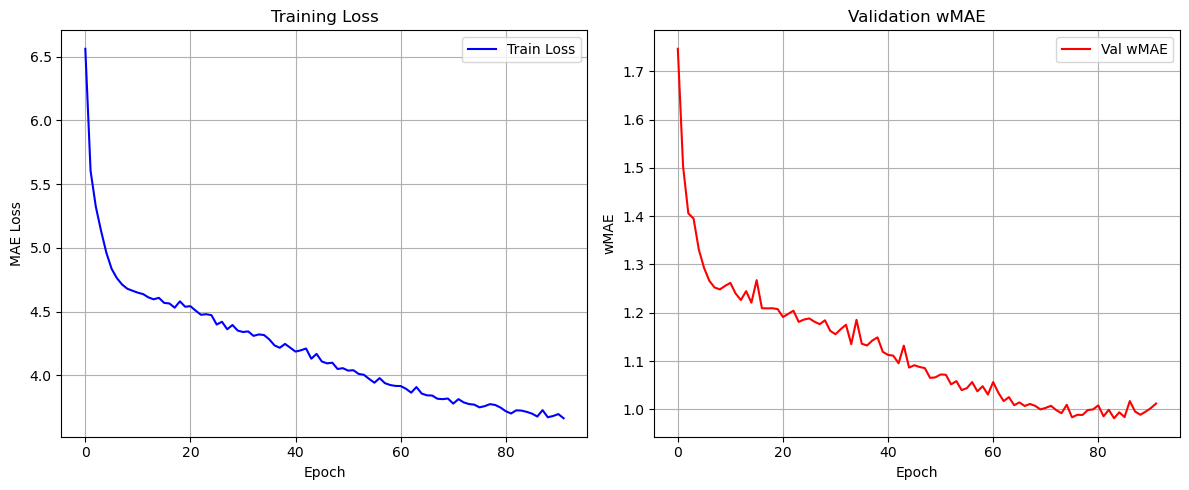

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()

# Plot validation wMAE
plt.subplot(1, 2, 2)
plt.plot(val_wmaes, 'r-', label='Val wMAE')
plt.xlabel('Epoch')
plt.ylabel('wMAE')
plt.title('Validation wMAE')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## 9. Generate Submission
Load the best model, predict on test set, and create submission file.


In [16]:
# Load best model
checkpoint = torch.load('best_finetuned_polymer_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model from epoch {checkpoint['epoch']+1} with val_wmae: {checkpoint['val_wmae']:.4f}")

# Load test data
test_csv = pd.read_csv(os.path.join(DATA_ROOT, 'test.csv'))
test_ids = test_csv['id'].values
test_loader = DataLoader(
    LMDBDataset(test_ids, TEST_LMDB),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

# Predict on test set
model.eval()
test_preds = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc='Predicting test set'):
        batch = batch.to(device)
        pred = model(batch)
        test_preds.append(pred.cpu().numpy())

test_preds = np.concatenate(test_preds, axis=0)

# Create submission DataFrame
submission = pd.DataFrame(test_preds, columns=label_cols)
submission.insert(0, 'id', test_ids)

# Save submission
submission.to_csv('submission.csv', index=False)
print('\nSubmission file created: submission.csv')
print('Shape:', submission.shape)
print('\nFirst few rows:')
print(submission.head())

Loaded model from epoch 50 with val_wmae: 0.9381


C:\Users\mattg\AppData\Local\Temp\ipykernel_13500\2441331439.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_finetuned_polymer_model.pt')


Predicting test set:   0%|          | 0/1 [00:00<?, ?it/s]


Submission file created: submission.csv
Shape: (3, 6)

First few rows:
           id          Tg       FFV        Tc   Density         Rg
0  1109053969  114.583847  0.393100  0.221922  1.316108  15.131016
1  1422188626  146.012985  0.383206  0.296551  1.242010  14.425700
2  2032016830  124.764076  0.361434  0.349780  1.260583  13.988169


## 10. Next Steps

Possible improvements:
1. Unfreeze backbone for fine-tuning
2. Add gap feature (`use_gap=True`)
3. Try different learning rates
4. Add data augmentation
5. Experiment with model architecture
6. Ensemble multiple models
